# Table of Contents
 <p><div class="lev1"><a href="#Imports"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1"><a href="#Load-data"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev2"><a href="#Load-Reference-dataset"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load Reference dataset</a></div><div class="lev2"><a href="#Load-iPSC-dataset"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load iPSC dataset</a></div><div class="lev2"><a href="#Load-ES-dataset"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Load ES dataset</a></div><div class="lev1"><a href="#Annotations"><span class="toc-item-num">3&nbsp;&nbsp;</span>Annotations</a></div><div class="lev2"><a href="#Describe-the-prototypic-cell-types"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Describe the prototypic cell types</a></div><div class="lev1"><a href="#Prepare-to-train-the-model"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prepare to train the model</a></div><div class="lev2"><a href="#Add-day0-ES-to-the-Reference-Dataset"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Add day0 ES to the Reference Dataset</a></div><div class="lev2"><a href="#Filter-for-Development-genes"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Filter for Development genes</a></div><div class="lev2"><a href="#Variable-genes-in-the-whole-ES-dataset"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Variable genes in the whole ES dataset</a></div><div class="lev2"><a href="#Avoid-to-select-genes-that-are-cell-culture-specific"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Avoid to select genes that are cell-culture specific</a></div><div class="lev2"><a href="#Enrichment:-Select-for-cell-type-positive-markers-(optional)"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Enrichment: Select for cell type positive markers (optional)</a></div><div class="lev1"><a href="#Train-model"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train model</a></div><div class="lev2"><a href="#Prepare-the-reference-dataset"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Prepare the reference dataset</a></div><div class="lev2"><a href="#Regularization-Path"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Regularization Path</a></div><div class="lev2"><a href="#Final-model"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Final model</a></div><div class="lev1"><a href="#Score-with-the-model"><span class="toc-item-num">6&nbsp;&nbsp;</span>Score with the model</a></div><div class="lev1"><a href="#Viualize-the-top-positive-coefficients-for-DA-neurons"><span class="toc-item-num">7&nbsp;&nbsp;</span>Viualize the top positive coefficients for DA neurons</a></div><div class="lev1"><a href="#Wheel/Polygonal-plot"><span class="toc-item-num">8&nbsp;&nbsp;</span>Wheel/Polygonal plot</a></div><div class="lev2"><a href="#Prepare"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Prepare</a></div><div class="lev2"><a href="#Plot-wheel-plot"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Plot wheel plot</a></div>

# Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#imports
from __future__ import division
import pandas as pd
from backSPIN import fit_CV
from Cef_tools import *
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cross_validation import StratifiedShuffleSplit  
from collections import defaultdict

# Load data

## Load Reference dataset

In [3]:
df_all, rows_annot, cols_annot, _ = cef2df('data/Human_Embryo_fulldataset.cef')

In [4]:
# For this analysis we masked the following genes
panther_cellcycle = open('data/PANTHER_cell_cycle_genes.txt').read().split('\n')
blood_genes = ['HBG1','HBA1','HBA2','HBE1','HBZ','BLVRB','S100A6']
SNAR_genes = ['SNAR-E', 'SNAR-A13_loc1', 'SNAR-C1_loc1', 'SNAR-A1_loc2', 'SNAR-A8_loc1', 'SNAR-C1_loc2', 'SNAR-A2_loc2', 'SNAR-C4', 
              'SNAR-A12_loc1', 'SNAR-C3', 'SNAR-C1_loc3', 'SNAR-G2', 'SNAR-G1', 'SNAR-A11_loc9', 'SNAR-A6_loc3', 'SNAR-A14_loc7', 'SNAR-A6_loc5', 
              'SNAR-A10_loc6', 'SNAR-A5_loc9', 'SNAR-A14_loc3', 'SNAR-A9_loc9', 'SNAR-A11_loc7', 'SNAR-B1_loc1', 'SNAR-B1_loc2', 'SNAR-D', 'SNAR-F']

df = df_all.ix[~in1d(df_all.index, panther_cellcycle) &\
               ~in1d(df_all.index, blood_genes)&\
               ~in1d(df_all.index, SNAR_genes),:]

## Load iPSC dataset

In [5]:
df_ips, rows_annot_ips, cols_annot_ips, _ = cef2df('data/iPSC_fulldataset.cef')

## Load ES dataset

In [6]:
df_es, rows_annot_es, cols_annot_es, _ = cef2df('data/ES_fulldataset.cef')

# Annotations

## Describe the prototypic cell types

In [7]:
# prototype dictionary
proto = pd.Series({'hEndo':   'Endo',
       
       'hPeric':  'Peric',
       
       'hMgl':    'Mgl',
       
       'hDA1':    'DA',
       'hDA2':    'DA',
       'hDA0':    'DA',
       
       'hSert':   'Sert',
       
       'hOMTN':   'OMTN',
       
       'hRgl1': 'Rgl',
       'hRgl3':   'Rgl',
       'hRgl2c':   'Rgl',
       'hRgl2b':   'Rgl',
       'hRgl2a':   'Rgl',
       
       'hOPC':    'OPC',
       
       'hProgFPM':'ProgFP',
       'hProgFPL':'ProgFP',
       'hProgM': 'ProgFP',
       
       'hProgBP': 'ProgBP',
       
       'hNbML5':  'Gaba',
       'hGaba':  'Gaba',
       'hNbGaba':  'Gaba',
       
       'hNbML1':  'NbML1',
       
       'hNProg':   'NProg',
       'hNbM':    'NbM',
       
       'hRN':     'RN',
       
       'eSCa': 'eES',
       'eSCb': 'eES',
       'eSCc': 'eES',

       'Unk': 'none'})

# Colors of the prototypes
protocol = {'NbML1':(100, 100, 240) ,
         'ProgFP':(160, 235, 235),
         'Gaba':(7,121,61),
         'ProgBP': (230, 140, 120),
         'NProg':(255, 195,  25),
         'Rgl':(175,175,35),
         'NbM':(180,140,130),
         'DA':(190,200,190),
         'OMTN':(0,240,0),
         'RN':(200,120,0),
         'Mgl': (217,245,7),
         'Peric': (225,160,30),
         'Endo': (190,10,10),
         'OPC':(255, 95, 105),
         'Sert':( 50, 180, 180),
         'eES':(240,255,250)}

# Prepare to train the model

Since we merge ES cell in culture with in vivo cell, feature selection is performed taking extra precautions to avoid picking up signature of the cell culture condition rather than the ES cell signature.

## Add day0 ES to the Reference Dataset

In [8]:
df_merge = pd.concat([df, df_es.ix[:,in1d(cols_annot_es.ix['Cell_type'], ['eSCa','eSCb','eSCc'])] ], axis=1)
df_merge = df_merge.dropna(axis=0)
df_merge.shape

(16229, 2298)

## Filter for Development genes

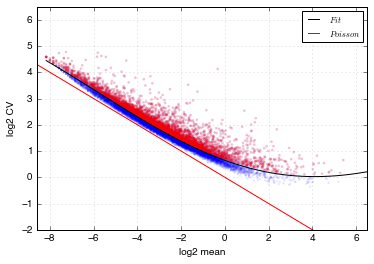

In [9]:
thrs = 4500

#Pre-filtering
df_f = df_merge.copy()
df_f = df_f.ix[sum(df_f>=1, 1)>=5,:] # is at least 1 in X cells
df_f = df_f.ix[sum(df_f>=2, 1)>=2,:] # is at least 2 in X cells
df_f = df_f.ix[sum(df_f>=3, 1)>=1,:] # is at least 2 in X cells

#Fitting
mu = df_f.mean(1).values
sigma = df_f.std(1, ddof=1).values
cv = sigma/mu
score, mu_linspace, cv_fit , params = fit_CV(mu,cv, 'SVR', svr_gamma=0.005)

#Plotting
def plot_cvmean():
    figure()
    scatter(log2(mu),log2(cv), marker='o', edgecolor ='none',alpha=0.1, s=5)
    mu_sorted = mu[argsort(score)[::-1]]
    cv_sorted = cv[argsort(score)[::-1]]
    scatter(log2(mu_sorted[:thrs]),log2(cv_sorted[:thrs]), marker='o', edgecolor ='none',alpha=0.15, s=8, c='r')
    plot(mu_linspace, cv_fit,'-k', linewidth=1, label='$Fit$')
    plot(linspace(-9,7), -0.5*linspace(-9,7), '-r', label='$Poisson$')
    ylabel('log2 CV')
    xlabel('log2 mean')
    grid(alpha=0.3)
    xlim(-8.6,6.5)
    ylim(-2,6.5)
    legend(loc=1, fontsize='small')
    gca().set_aspect(1.2)
    
plot_cvmean()

#Adjusting plot


#Confirm Selection
df_dev = df_f.ix[argsort(score)[::-1],:].ix[:thrs,:]

## Variable genes in the whole ES dataset

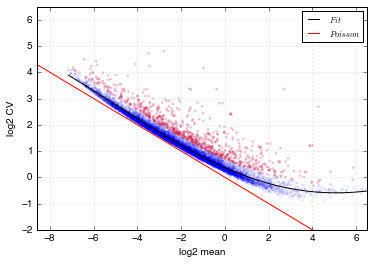

In [10]:
thrs = 800

#Pre-filtering
df_f = df_es.copy()
df_f = df_f.ix[sum(df_f>=1, 1)>=7,:] # is at least 1 in X cells
df_f = df_f.ix[sum(df_f>=2, 1)>=3,:] # is at least 2 in X cells
df_f = df_f.ix[sum(df_f>=3, 1)>=1,:] # is at least 2 in X cells

#Fitting
mu = df_f.mean(1).values
sigma = df_f.std(1, ddof=1).values
cv = sigma/mu
score, mu_linspace, cv_fit , params = fit_CV(mu,cv, 'SVR', svr_gamma=0.005)

#Plotting
plot_cvmean()

#Confirm Selection
variable_es =  df_f.ix[argsort(score)[::-1],:].ix[:thrs,:].index

## Avoid to select genes that are cell-culture specific
The selected genes coming from ES must have a minimal variabiliry in the full ES dataset

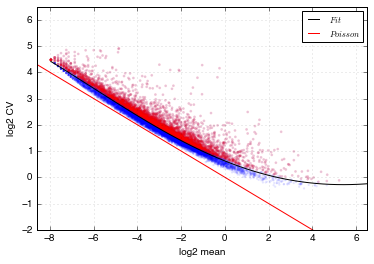

In [11]:
thrs = 4500

#Pre-filtering
df_f = df.copy()
df_f = df_f.ix[sum(df_f>=1, 1)>=5,:] # is at least 1 in X cells
df_f = df_f.ix[sum(df_f>=2, 1)>=2,:] # is at least 2 in X cells
df_f = df_f.ix[sum(df_f>=3, 1)>=1,:] # is at least 2 in X cells

#Fitting
mu = df_f.mean(1).values
sigma = df_f.std(1, ddof=1).values
cv = sigma/mu
score, mu_linspace, cv_fit , params = fit_CV(mu,cv, 'SVR', svr_gamma=0.005)

#Plotting
plot_cvmean()

#Confirm Selection
variable_emb =  df_f.ix[argsort(score)[::-1],:].ix[:thrs,:].index

In [12]:
es_batch_genes = setdiff1d( setdiff1d(df_dev.index, variable_emb), variable_es )
df_dev = df_dev.ix[~in1d(df_dev.index,es_batch_genes),:]
df_dev.shape

(3789, 2298)

## Enrichment: Select for cell type positive markers (optional)
This is not essential since the regularization in the logistic regression works as a feature selection.
However we reasoned filtering genes that are not enriched in any cell-type (e.g. methabolic, early immediate, cell cycle or others are orthogonal to cell type) may produce a model that can generalize better when applied on cells in different environment (e.g. cell cultures, differentiation experiments).

In [13]:
# for some single cell types
enrichment_order = ['hEndo', 'hPeric','hMgl','hSert','hOMTN','hOPC','hProgBP','hNbML1',
                    'hNProg','hNbM','hRN','eSCa','eSCb','eSCc','hNbML5','hGaba','hNbGaba',
                    'hDA1','hDA2','hDA0','hRgl2b','hRgl2a','hRgl3','hRgl1','hRgl2c',
                    'hProgFPM','hProgFPL','hProgM','hProgBP']
# for prototypes
higher_order = [['hDA1','hDA2','hDA0'],['hRgl2c','hRgl2b','hRgl2a','hRgl3','hRgl1'],
                ['hProgFPM','hProgFPL','hProgM'],['hNbML5','hGaba','hNbGaba'],
                ['eSCa','eSCb','eSCc']]

In [14]:
cols_annot_all = pd.concat( [cols_annot, cols_annot_ips, cols_annot_es], 1)

In [15]:
ct_dev = cols_annot_all[df_dev.columns].ix['Cell_type']
protogruop = proto.ix[ct_dev].values

In [16]:
df_fall = df_dev.ix[:,protogruop != 'none']
df_fall = df_fall.ix[(df_fall.sum(1)>6) & ((df_fall>0).sum(1)>4),:]
cell_types = cols_annot_all[df_fall.columns].ix['Cell_type'].values
df_means = df_fall.mean(1) + 1e-5
df_bin = df_fall>0
df_fold = pd.DataFrame()
df_avgpos = pd.DataFrame()
for ct in enrichment_order:
    df_fold[ct] = df_fall.ix[:,cell_types == ct].mean(1) / df_means
    df_avgpos[ct] = df_bin.ix[:,cell_types == ct].mean(1)
    
for ct in higher_order:
    df_fold['-'.join(ct)] = df_fall.ix[:,in1d(cell_types, ct)].mean(1) / df_means
    df_avgpos['-'.join(ct)] = df_bin.ix[:,in1d(cell_types, ct)].mean(1)

In [17]:
score00 = df_fold
score05 = df_fold * df_avgpos**0.5
score10 = df_fold * df_avgpos

ix00 = argsort( score00 , 0)
ix05 = argsort( score05 , 0)
ix10 = argsort( score10 , 0)

In [18]:
markers = defaultdict(set)
N = 145
for ct in df_fold.columns:
    markers[ct] |= set( df_fold.index[ix00.ix[:,ct][::-1]][:N] )
    markers[ct] |= set( df_fold.index[ix05.ix[:,ct][::-1]][:N] )
    markers[ct] |= set( df_fold.index[ix10.ix[:,ct][::-1]][:N] )

In [19]:
for ct in df_fold.columns:
    for mk in markers[ct]:
        for ct2 in list( set(df_fold.columns) - set([ct])):
            if score10.ix[mk,ct] >= score10.ix[mk,ct2]:
                markers[ct2] -= set([mk])
    for mk in list(markers[ct]):
        if df_avgpos.ix[mk,ct] < 0.15:
            markers[ct] -= set([mk])

In [20]:
list_genes = sum([list(markers[ct]) for ct in df_fold.columns])
len(list_genes)

1969

In [21]:
df_dev = df_dev.ix[list(set(list_genes)),:]

# Train model

## Prepare the reference dataset

In [22]:
# Log normalization
df_dev_log = log2(df_dev+1)
df_ips_log = log2( df_ips+1 )
df_es_log = log2( df_es+1 )

In [23]:
# Check if this is repeated
ct_dev = cols_annot_all[df_dev.columns].ix['Cell_type']
protogruop = proto.ix[ct_dev].values

In [24]:
bool1 = protogruop != 'none'
classes_names, classes_index = unique(protogruop[bool1], return_inverse=True, return_counts=False)
train_index = classes_index
df_train_set = df_dev_log.ix[:,bool1].copy()
train_index = classes_index

## Regularization Path

In [ ]:
LR = LogisticRegressionCV(Cs=logspace(-3.25,0.8,30), refit=True, penalty='l2',
                          solver='newton-cg', fit_intercept=False, multi_class='multinomial',class_weight='balanced',
                          cv=StratifiedShuffleSplit(train_index, n_iter=35,test_size=0.15, random_state=150790))
normalizer = 0.9*df_train_set.values.max(1)[:,newaxis]
LR.fit((df_train_set.values/normalizer).T, train_index)

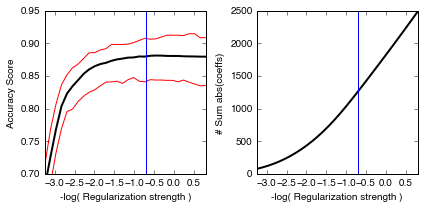

In [26]:
figure(figsize=(6,3))
    
chos = 0.2

subplot(122)
CMA = array([abs(LR.coefs_paths_[i]) for i in range(len(set(classes_index)))])
val_ = array( [[sum( sum( CMA[:,i,j,:],0) ,0) for i in range(35)] for j in range(30) ] )
plot( log10(LR.Cs_),\
     val_.mean(1), c='k' , lw=2 )
xlabel('-log( Regularization strength )')
ylabel('# Sum abs(coeffs)')
xlim(-3.25,0.8)
axvline( log10(chos) )

subplot(121)
plot(log10(LR.Cs_), mean([LR.scores_[i].mean(0) for i in range(len(set(classes_index)))],0), c='k', lw=2 )
plot(log10(LR.Cs_), percentile( LR.scores_[1],97.5,0), c='r')
plot(log10(LR.Cs_), percentile( LR.scores_[1],2.5,0), c='r')
axvline( log10(chos) )
ylabel('Accuracy Score')
xlabel('-log( Regularization strength )')
xlim(-3.25,0.8)
ylim(0.70,0.95)

tight_layout()

## Final model

In [25]:
# Normalized by the max
LR = LogisticRegression(C=0.2, penalty='l2', solver='newton-cg', fit_intercept=False,
                        multi_class='multinomial',class_weight='balanced',random_state=150790)
normalizer = 0.9*df_train_set.values.max(1)[:,newaxis]
LR.fit((df_train_set.values / normalizer).T, train_index)

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=150790, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

# Score with the model

In [26]:
hist_order = ['Endo', 'Peric', 'Mgl', 'OPC',  'eES','Rgl','ProgBP','ProgFP','NProg',   
              'RN', 'NbM','NbML1','DA','Gaba','Sert','OMTN',]
hist_ixes = [list(classes_names).index(i) for i in hist_order]

In [27]:
classes_names

array(['DA', 'Endo', 'Gaba', 'Mgl', 'NProg', 'NbM', 'NbML1', 'OMTN', 'OPC',
       'Peric', 'ProgBP', 'ProgFP', 'RN', 'Rgl', 'Sert', 'eES'], dtype=object)

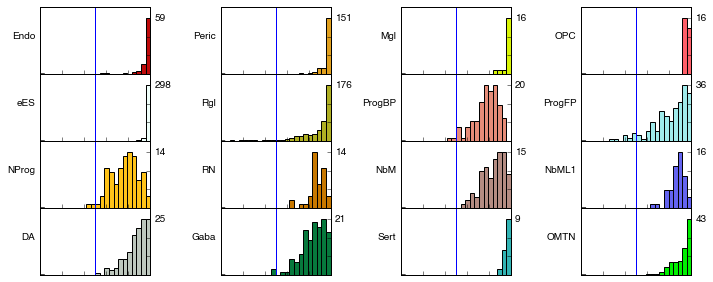

In [28]:
figure(figsize=(10,4))
pobs_list = []
for z,i in enumerate(hist_ixes):
    subplot(len(set(classes_index))/4,4,z+1)
    prob = LR.predict_proba((df_train_set.values[:,classes_index==i]/ normalizer).T)[:,i]
    amounts,_,_ = hist(prob, color=array(protocol[classes_names[i]])/255.,bins=linspace(0,1,25) )
    pobs_list.append([ classes_names[i], mean(prob)])
    
    if z == len(hist_ixes)-1:
        tick_params('both',which='both', right='on',left='off',top='off',
                    labelleft='off',labelbottom='on',labelright='on')
    axvline(0.5)
    xlim(0.,1)
    ylabel(classes_names[i],rotation='horizontal',horizontalalignment = 'right')
    yticks(linspace(0,max(amounts), 4 )[1:],['','','%d' % ( max(amounts) )])
    ylim(0,1.2*max(amounts))
    tick_params('both',which='both', right='on',left='off',top='off',
                    labelleft='off',labelbottom='off',labelright='on')
tight_layout(pad=1,h_pad=0,w_pad=1)

# Viualize the top positive coefficients for DA neurons

In [29]:
sel_class = 'DA'
nonzero_coef_bool = LR.coef_[ where( classes_names == sel_class )[0][0],: ] > 0
values_nonzero_coef = LR.coef_[ where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_dev_log.index[nonzero_coef_bool]

ix_nonzero_coef = argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_dev.ix[names_sorted_coef, protogruop == sel_class].mean(1)
std_expr = df_dev.ix[names_sorted_coef, protogruop == sel_class].std(1)

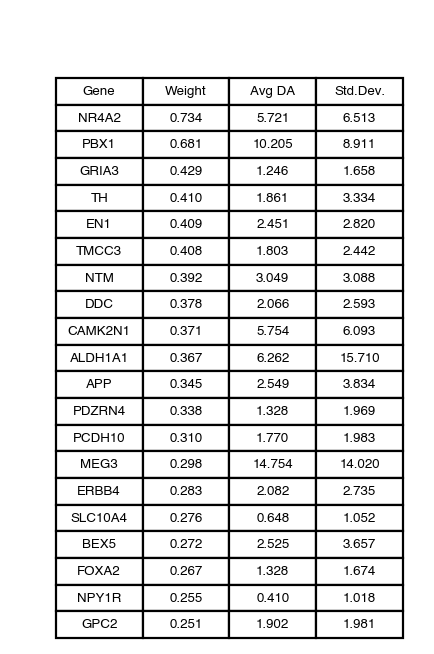

In [30]:
# Plot in a matplotlib table
rcParams['savefig.dpi'] = 160
colLabels=("Gene", "Weight", 'Avg %s' % sel_class, 'Std.Dev.')
rows_list = zip( list(names_sorted_coef)[:20],\
                map(lambda x: '%.3f' % x, values_sorted_coef)[:20],\
                map(lambda x: '%.3f' % x, avg_expr[:20]),\
                map(lambda x: '%.3f' % x, std_expr[:20]))
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = plt.figure(figsize=(ncols*wcell+wpad, nrows*hcell+hpad))
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')

# Wheel/Polygonal plot

## Prepare 

In [31]:
def polygonalPlot(data, scaling=True,start_angle=90, rotate_labels=True, labels=('one','two','three'),\
                sides=3, label_offset=0.10, edge_args={'color':'black','linewidth':2},\
                fig_args = {'figsize':(8,8),'facecolor':'white','edgecolor':'white'},):
    '''
    This will create a basic polygonal plot

    # Scale data for plot (i.e. a + b + c = 1)
    scaling=True,
    # Direction of first vertex.
    start_angle=90,
    # Orient labels perpendicular to vertices.
    rotate_labels=True,
    # Labels for vertices.
    labels=('one','two','three')
    # Offset for label from vertex (percent of distance from origin).
    label_offset=0.10,
    # Any matplotlib keyword args for plots.
    edge_args={'color':'black','linewidth':2},
    # Any matplotlib keyword args for figures.
    fig_args = {'figsize':(8,8),'facecolor':'white','edgecolor':'white'},
    '''
    basis = array([[cos(2*i*pi/sides + start_angle*pi/180),
                    sin(2*i*pi/sides + start_angle*pi/180)] for i in range(sides)])

    # If data is Nxsides, newdata is Nx2.
    if scaling:
        # Scales data
        newdata = dot((data.T / data.sum(-1)).T,basis)
    else:
        # Assumes data already sums to 1.
        newdata = dot(data,basis)

    fig = figure(**fig_args)
    ax = fig.add_subplot(111)

    for i,l in enumerate(labels):
        if i >= sides:
            break
        x = basis[i,0]
        y = basis[i,1]
        if rotate_labels:
            angle = 180*arctan(y/x)/pi + 90
            if angle > 90 and angle <= 270:
                angle = mod(angle + 180,360)
        else:
            angle = 0
        ax.text(
                x*(1 + label_offset),
                y*(1 + label_offset),
                l,
                horizontalalignment='center',
                verticalalignment='center',
                rotation=angle
            )

    # Clear normal matplotlib axes graphics
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_frame_on(False)

    # Plot borders
    ax.plot([basis[_,0] for _ in range(sides) + [0,]],
            [basis[_,1] for _ in range(sides) + [0,]],
            **edge_args)

    return newdata,ax

## Plot wheel plot

In [32]:
wanted_order = ['NProg', 'ProgFP','eES', 'ProgBP', 'Rgl', 
         'Gaba', 'Sert','DA','OMTN','RN', 'NbM','NbML1',]
reorder_ix = [list(classes_names).index(i) for i in wanted_order]
bool00 = in1d( classes_names[classes_index],  wanted_order )

In [33]:
color_dict = pd.Series({'hEndo':   (190,  10,  10),'hPeric': (225, 160,  30),'hMgl':    (217, 245,   7),
              'hDA1':    (170, 180, 170),'hDA2':   (130, 140, 140),'hNbM':    (180, 140, 130),
              'hNbML1':  (100, 100, 240),'hProgM': ( 80, 235, 255),'hProgFPM':(190, 235, 255),
              'hProgFPL':(210, 255, 215),'hProgBP':(230, 140, 120),'hNProg':  (255, 195,  28),
              'hNbML5':  (139, 101, 100),'hRgl1':  (252, 183,  26),'hRgl3':   (214, 194,  39),
              'hRgl2c':  (255, 120, 155),'hRgl2b': (250, 145,  45),'hRgl2a':  (250, 125,  25),
              'hDA0':    (190, 200, 190),'hOPC':   (255,  35, 155),'hRN':     (199, 121,  41),
              'hNbGaba': ( 40,  55, 130),'hGaba':  (  7,  121, 61),'hOMTN':   ( 95, 186,  70),
              'hSert':   ( 50, 180, 180),'eSCa':   (245, 205, 170),'eSCb':    (205, 245, 170),
              'eSCc':(205,205,220)})
color_dict = color_dict.map(lambda x: map(lambda y: y/255., x))

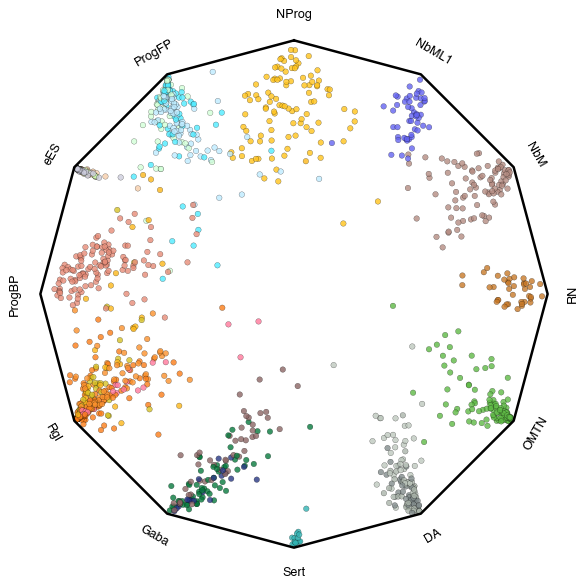

In [35]:
rcParams['savefig.dpi'] = 90
newcolors = array(list(color_dict[cols_annot_all.ix[:,df_train_set.columns].ix['Cell_type']].values))

newdata,ax = polygonalPlot(LR.predict_proba((df_train_set.values/ df_train_set.values.max(1)[:,newaxis]).T)[:,reorder_ix],\
                         scaling=False, sides=len(reorder_ix), labels=classes_names[reorder_ix])

ax.scatter( newdata[bool00,0]*0.99, newdata[bool00,1]*0.99, alpha=0.8,\
           c=newcolors[bool00,:],\
           s =20, lw=0.2)